# Part 2. Open Queuing network simulation (8 pt)

The second part of the project is to make an open-queuing network simulator, where the jobs arrive from the outside following Poisson processes with the rate of lambda. 

Each job needs to go to the CPU, following an exponential distribution with a mean of 10 jobs per second, and then proceeds by either one of the disks. There are two disks, each of which has an exponentially-distributed processing time. The fast disk has a processing rate of 12 jobs per second and the slow disk has the rate of 9 jobs per second. The number of buffer spaces in each queue is infinite.


In [9]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Random number generator with a fixed seed for reproducibility
RNG = np.random.default_rng(seed=42)

class OpenQueueNet:
    def __init__(self, lambda_, mu_cpu=10, mu_fast=12, mu_slow=9, policy="single", warmup=1000):
        """
        Set up the simulation environment and parameters.
        lambda_ : external arrival rate
        mu_cpu, mu_fast, mu_slow : service rates for CPU and disks
        policy : disk routing policy ("single" or "shortest")
        warmup : time to discard initial transient period
        """

        # Simulation environment
        self.env = simpy.Environment()

        # Convert rates to mean times for exponential distributions
        self.lambda_ = lambda_
        self.beta_arr = 1 / lambda_      # mean inter-arrival time
        self.beta_cpu = 1 / mu_cpu
        self.beta_fast = 1 / mu_fast
        self.beta_slow = 1 / mu_slow

        # Routing policy
        self.policy = policy

        # Warm-up period
        self.warmup = warmup

        # Resources: CPU and two disks (each can handle 1 job at a time)
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.fast_disk = simpy.Resource(self.env, capacity=1)
        self.slow_disk = simpy.Resource(self.env, capacity=1)

        # Stats: completed jobs and response times (after warm-up)
        self.completed_jobs = 0
        self.response_times = []

    def cpu_process(self, job_id, arrival_time):
        """
        Simulate a job going through the CPU.
        After CPU, send it to a disk according to the policy.
        """

        # Request CPU
        with self.cpu.request() as req:
            yield req
            # CPU service time (exponentially distributed)
            yield self.env.timeout(RNG.exponential(self.beta_cpu))

        # Send job to disk
        if self.policy == "single":
            yield self.env.process(self.shared_disk(job_id, arrival_time))
        else:
            yield self.env.process(self.shortest_queue_disk(job_id, arrival_time))

    def shared_disk(self, job_id, arrival_time):
        """
        Single queue for both disks: randomly pick fast or slow disk.
        """

        if RNG.random() < 0.5:
            disk, beta = self.fast_disk, self.beta_fast
        else:
            disk, beta = self.slow_disk, self.beta_slow

        # Request disk
        with disk.request() as req:
            yield req
            yield self.env.timeout(RNG.exponential(beta))

        # Record stats only after warm-up period
        if self.env.now >= self.warmup:
            self.completed_jobs += 1
            self.response_times.append(self.env.now - arrival_time)

    def shortest_queue_disk(self, job_id, arrival_time):
        """
        Send job to the disk with the shortest queue.
        Each disk has its own queue now.
        """

        # Pick disk with smaller queue length
        if len(self.fast_disk.queue) <= len(self.slow_disk.queue):
            disk, beta = self.fast_disk, self.beta_fast
        else:
            disk, beta = self.slow_disk, self.beta_slow

        # Request disk
        with disk.request() as req:
            yield req
            yield self.env.timeout(RNG.exponential(beta))

        # Record stats only after warm-up period
        if self.env.now >= self.warmup:
            self.completed_jobs += 1
            self.response_times.append(self.env.now - arrival_time)

    def job_generator(self):
        """
        Generate jobs arriving from outside according to a Poisson process.
        """

        job_id = 0
        while True:
            # Wait until the next job arrives
            yield self.env.timeout(RNG.exponential(self.beta_arr))
            arrival_time = self.env.now

            # Start CPU process for the new job
            self.env.process(self.cpu_process(job_id, arrival_time))
            job_id += 1

    def run(self, T):
        """
        Run the simulation for T time units.
        """

        # Start generating jobs
        self.env.process(self.job_generator())
        self.env.run(until=T)

    def results(self, T):
        """
        Calculate throughput and average response time.
        Only counts jobs completed after warm-up.
        """

        # Effective simulation time after warm-up
        effective_time = max(T - self.warmup, 1)  # avoid division by zero

        # Throughput and average response time
        throughput = self.completed_jobs / effective_time
        avg_rt = np.mean(self.response_times)
        return throughput, avg_rt


## Question 1

In [10]:
# Total simulation time
T = 10_000

# List of arrival rates to test, going from low to very high
lambdas = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

throughputs = []
response_times = []

# Loop over each arrival rate
for lam in lambdas:
    # Create a new simulation with the current lambda and single-queue policy
    sim = OpenQueueNet(lambda_=lam, policy="single")
    
    # Run the simulation for T time units
    sim.run(T)
    
    # Get throughput and average response time
    thr, rt = sim.results(T)

    throughputs.append(thr)
    response_times.append(rt)
    
    # Print results nicely formatted
    print(f"λ={lam:>2} | throughput={thr:.2f} | avg RT={rt:.2f}")


λ= 6 | throughput=6.01 | avg RT=0.39
λ= 8 | throughput=7.99 | avg RT=0.65
λ= 9 | throughput=8.98 | avg RT=1.24
λ=10 | throughput=9.96 | avg RT=65.33
λ=11 | throughput=10.03 | avg RT=478.54
λ=12 | throughput=9.98 | avg RT=929.99
λ=13 | throughput=10.03 | avg RT=1255.51
λ=14 | throughput=9.92 | avg RT=1598.25
λ=15 | throughput=10.02 | avg RT=1810.95
λ=16 | throughput=10.01 | avg RT=2091.30
λ=17 | throughput=10.08 | avg RT=2231.83
λ=18 | throughput=9.98 | avg RT=2466.46
λ=19 | throughput=10.00 | avg RT=2612.22
λ=20 | throughput=9.97 | avg RT=2765.77


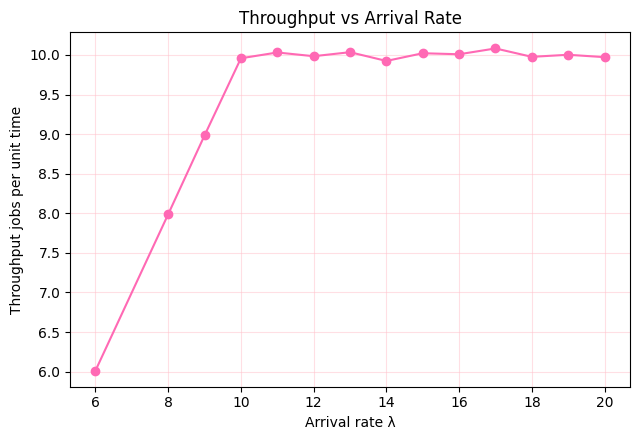

In [11]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(lambdas, throughputs, marker="o", color = "hotpink")

plt.xlabel("Arrival rate λ")
plt.ylabel("Throughput jobs per unit time")
plt.title("Throughput vs Arrival Rate")

plt.grid(True, alpha=0.5, color = "pink")
plt.tight_layout()
plt.show()


For λ up to around 9, the system handles all arrivals smoothly, so throughput roughly matches λ and response times stay low. However, once λ reaches 10 or higher, response times start to explode while throughput stays around 10 jobs per unit time. This happens because the CPU is the bottleneck. In fact, every job must go through it first, and it can only process about 10 jobs per unit time on average. The disks don’t limit throughput, since there are two working in parallel and their combined capacity is higher than what the CPU can feed them. From this, we can conclude that the maximum sustainable throughput of the system is roughly 10 jobs per unit time, because adding more arrivals beyond this point only increases waiting times, not throughput.

## Question 2

In [14]:
rt_single = []
rt_shortest = []
test_lambdas = [3, 7, 10]

for lam in test_lambdas:
    sim_single = OpenQueueNet(lambda_=lam, policy="single")
    sim_single.run(T)
    thr_s, rt_s = sim_single.results(T)
    rt_single.append(rt_s)

    sim_short = OpenQueueNet(lambda_=lam, policy="shortest")
    sim_short.run(T)
    thr_q, rt_q = sim_short.results(T)
    rt_shortest.append(rt_q)

    print(
        f"λ={lam:>2} | "
        f"Single RT={rt_s:.2f} | "
        f"Shortest RT={rt_q:.2f}"
    )


λ= 3 | Single RT=0.26 | Shortest RT=0.24
λ= 7 | Single RT=0.47 | Shortest RT=0.45
λ=10 | Single RT=19.37 | Shortest RT=12.13


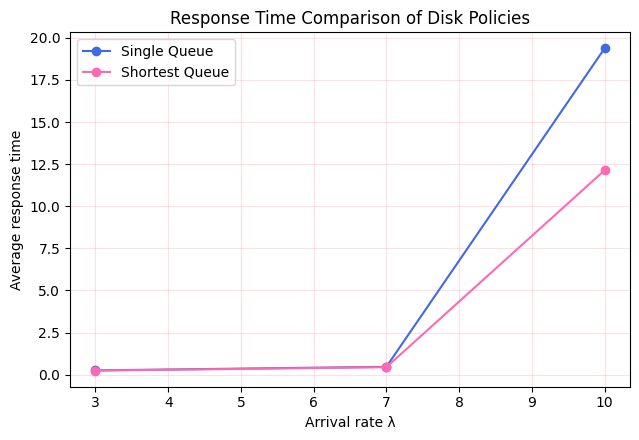

In [16]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(test_lambdas, rt_single, marker="o", label="Single Queue", color = "royalblue")
plt.plot(test_lambdas, rt_shortest, marker="o", label="Shortest Queue", color = "hotpink")

plt.xlabel("Arrival rate λ")
plt.ylabel("Average response time")
plt.title("Response Time Comparison of Disk Policies")

plt.grid(True, alpha=0.5, color = "pink")
plt.legend()
plt.tight_layout()
plt.show()


We measured the average response times for three arrival rates using both disk routing policies. For λ equal to 3, the response time is 0.26 with the single queue policy and 0.24 with the shortest queue policy, so there is almost no difference since the system is very lightly loaded. When λ is increased to 7, the response time becomes 0.47 for the single queue and 0.45 for the shortest queue, which is still close, but we can already see that the shortest queue policy does a bit better. Things change much more when λ reaches 10. In that case, the response time jumps to 19.37 with the single queue policy, while it is 12.13 with the shortest queue policy. This is a pretty big gap, and it shows that when the system starts to get really busy, sending jobs to the disk with the shorter queue actually matters a lot. At low arrival rates both strategies behave almost the same, but near saturation the shortest queue policy clearly helps reduce how long jobs spend waiting in the system, even if it is not a perfect fix.